In [2]:
# Script to have different ways to train the tactile image
import glob
import h5py
import hydra
import mmap
import numpy as np
import os
import pickle
import torch 
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.utils.data as data 

from omegaconf import DictConfig, OmegaConf
from collections import OrderedDict
from tqdm import tqdm 
from torch.nn.parallel import DistributedDataParallel as DDP
from holobot.robot.allegro.allegro_kdl import AllegroKDL

from tactile_learning.utils.constants import *
from tactile_learning.models.custom import *
from tactile_learning.datasets.tactile_vision import *
from tactile_learning.deployment.load_models import * 
from tactile_learning.deployment.nn_buffer import NearestNeighborBuffer
from tactile_learning.models.knn import KNearestNeighbors, ScaledKNearestNeighbors
from tactile_learning.utils.visualization import *
from tactile_learning.utils.tactile_image import *
from tactile_learning.utils.data import load_data

In [3]:
# Tactile normalization training for all possible encoder types: alexnet pretrained, resnet pretrained, stacked cnn and single sensor cnns
# on top of previous implementations what is needed is to normalize them properly
# So this script will:
# 1. Find the mean and std of the current dataset
# 2. Find the min and max of the normalized dataset with the found dataset
# 3. Map the tactile images to bw 0,1 with these min and max
# 4. Then find the mean and std again
# 5. And use these mean and stds for BYOL training

In [4]:
PLAY_DATA_DIR = '/home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data'

In [26]:
# x = torch.FloatTensor([[1,4,532,3,5,6,2,4,7,3],
#                        [3,4,6,7,345,1,2,8,10,2],
#                        [34,5,7,90,3,2,1,67,0,34]])
x = torch.rand((2,3,16,16))
class XStats:
    def __init__(self, x):
        self.min_val = torch.Tensor([x[:,i,:,:].min() for i in range(3)]).unsqueeze(1).unsqueeze(1)
        self.max_val = torch.Tensor([x[:,i,:,:].max() for i in range(3)]).unsqueeze(1).unsqueeze(1)
        print('min_val: {}, max_val: {}'.format(self.min_val, self.max_val))
        self.transform = T.Lambda(self._scale_transform)
    def _scale_transform(self, x):
        x = (x-self.min_val) / (self.max_val - self.min_val)
        return x

    def getitem(self, x):
        return self.transform(x)
    
stats = XStats(x)
y = stats.getitem(x)
print(f'x: {x.max(), x.min()}, y: {y[:,0,:,:].max(),y[:,1,:,:].max(),y[:,2,:,:].max(), y[:,0,:,:].min(),y[:,1,:,:].min(),y[:,2,:,:].min()}')

min_val: tensor([[[0.0033]],

        [[0.0005]],

        [[0.0027]]]), max_val: tensor([[[0.9998]],

        [[0.9996]],

        [[0.9999]]])
x: (tensor(0.9999), tensor(0.0005)), y: (tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.))


In [14]:
class TactileBYOLDataset(data.Dataset):
    # Dataset for all possible tactile types (stacked, whole hand, one sensor)
    def __init__(
        self,
        data_path,
        tactile_information_type, # It could be either one of - stacked, whole_hand, single_sensor
        img_size,
        mean_std=None, # This is a general stats for all tactile information
        min_max=None # Minimum and maximum of the tactile dataset - if given none these values should be found by using this dataset
    ):
        super().__init__()
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)
        self.data = load_data(self.roots, demos_to_use=[])
        assert tactile_information_type in ['stacked', 'whole_hand', 'single_sensor'], 'tactile_information_type can either be "stacked", "whole_hand" or "single_sensor"'
        self.tactile_information_type = tactile_information_type
        
        # Set the transforms accordingly
        self.img_size = img_size
        self.min_max = min_max 
        self.mean_std = mean_std
            
        if mean_std is None:
            self.transform = T.Resize(img_size)
        elif min_max is None:
            self.transform = T.Compose([
                T.Resize(img_size),
                T.Normalize(mean_std[0], mean_std[1])
            ])
        else:
            self.transform = T.Compose([
                T.Resize(img_size),
                T.Normalize(mean_std[0], mean_std[1]),
                T.Lambda(self._scale_transform)
            ])
            
        # Set the indices for one sensor
        if tactile_information_type == 'single_sensor':
            self._preprocess_tactile_indices()
            
        # Set up the tactile image retrieval function
        if tactile_information_type == 'single_sensor':
            self._get_tactile_image = self._get_single_sensor_tactile_image
        elif tactile_information_type == 'stacked':
            self._get_tactile_image = self._get_stacked_tactile_image
        elif tactile_information_type == 'whole_hand':
            self._get_tactile_image = self._get_whole_hand_tactile_image
            
    def _preprocess_tactile_indices(self):
        self.tactile_mapper = np.zeros(len(self.data['tactile']['indices'])*15).astype(int)
        for data_id in range(len(self.data['tactile']['indices'])):
            for sensor_id in range(15):
                self.tactile_mapper[data_id*15+sensor_id] = data_id # Assign each finger to an index basically

    def _get_sensor_id(self, index):
        return index % 15
            
    def _scale_transform(self, image): # Transform function to map the image between 0 and 1
        image = (image - self.min_max[0]) / (self.min_max[1] - self.min_max[0])
        return image
            
    def _get_whole_hand_tactile_image(self, tactile_values): 
        # tactile_values: (15,16,3) - turn it into 16,16,3 by concatenating 0z
        tactile_image = torch.FloatTensor(tactile_values)
        tactile_image = F.pad(tactile_image, (0,0,0,0,1,0), 'constant', 0)
        # reshape it to 4x4
        tactile_image = tactile_image.view(16,4,4,3)

        # concat for it have its proper shape
        tactile_image = torch.concat([
            torch.concat([tactile_image[i*4+j] for j in range(4)], dim=0)
            for i in range(4)
        ], dim=1)

        tactile_image = torch.permute(tactile_image, (2,0,1))
        
        return self.transform(tactile_image)
    
    def _get_stacked_tactile_image(self, tactile_values):
        tactile_image = torch.FloatTensor(tactile_values)
        tactile_image = tactile_image.view(15,4,4,3) # Just making sure that everything stays the same
        tactile_image = torch.permute(tactile_image, (0,3,1,2))
        tactile_image = tactile_image.reshape(-1,4,4) # Make 45 the channel number 
        return self.transform(tactile_image)
    
    def _get_single_sensor_tactile_image(self, tactile_value):
        tactile_image = torch.FloatTensor(tactile_value) # tactile_value.shape: (16,3)
        tactile_image = tactile_image.view(4,4,3)
        tactile_image = torch.permute(tactile_image, (2,0,1))
        return self.transform(tactile_image)
    
    def __len__(self):
        if self.tactile_information_type == 'single_sensor':
            return len(self.tactile_mapper)
        else: 
            return len(self.data['tactile']['indices'])
        
    def _get_proper_tactile_value(self, index):
        if self.tactile_information_type == 'single_sensor':
            data_id = self.tactile_mapper[index]
            demo_id, tactile_id = self.data['tactile']['indices'][data_id]
            sensor_id = self._get_sensor_id(index)
            tactile_value = self.data['tactile']['values'][demo_id][tactile_id][sensor_id]
            
            return tactile_value
        
        else:
            demo_id, tactile_id = self.data['tactile']['indices'][index]
            tactile_values = self.data['tactile']['values'][demo_id][tactile_id]
            
            return tactile_values

    def __getitem__(self, index):
        tactile_value = self._get_proper_tactile_value(index)
        tactile_image = self._get_tactile_image(tactile_value)
        
        return tactile_image
        

In [7]:
whole_hand_dset = TactileBYOLDataset(
    data_path = PLAY_DATA_DIR,
    tactile_information_type = 'whole_hand', # It could be either one of - stacked, whole_hand, single_sensor
    img_size = 16,
    mean_std=None, # This is a general stats for all tactile information
    min_max=None # Minimum and maximum of the tactile dataset - if given none these values should be found by using this dataset
)

In [10]:
len_whole_hand_dset = len(whole_hand_dset)

In [21]:
def get_image_stats(len_image_dataset, image_loader, img_size):
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader):
        psum    += inputs.sum(axis = [0, 2, 3])
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

    # pixel count
    count = len_image_dataset * img_size * img_size

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))
    
    return total_mean, total_std

In [12]:
# Create the image_loader
tactile_loader = data.DataLoader(whole_hand_dset, 
                                batch_size  = 128, 
                                shuffle     = True, 
                                num_workers = 8,
                                pin_memory  = True)
whole_hand_mean, whole_hand_std = get_image_stats(
    len_whole_hand_dset, 
    tactile_loader,
    img_size = 16
)

100%|████████████████| 3481/3481 [00:06<00:00, 524.37it/s]


mean: tensor([ 0.1218,  0.7076, 12.5459])
std:  tensor([168.1889,  98.6576, 104.8352])


In [9]:
def find_min_max(image_loader, channel_num):
    min_val = torch.ones(channel_num) * 1000
    max_val = -torch.ones(channel_num) * 1000
    for inputs in tqdm(image_loader):
        curr_min_val = torch.Tensor([inputs[:,i,:,:].min() for i in range(channel_num)]).unsqueeze(1).unsqueeze(1)
        curr_max_val = torch.Tensor([inputs[:,i,:,:].max() for i in range(channel_num)]).unsqueeze(1).unsqueeze(1)
        
        for i in range(channel_num):
            min_val[i] = min(min_val[i], curr_min_val[i])
            max_val[i] = max(max_val[i], curr_max_val[i])
    
    print(f'min_val: {min_val}')
    print(f'max_val: {max_val}')
    
    return min_val, max_val



In [5]:
whole_hand_mean, whole_hand_std = torch.Tensor([ 0.1218,  0.7076, 12.5459]), torch.Tensor([168.1889,  98.6576, 104.8352])
whole_hand_dset = TactileBYOLDataset(
    data_path = PLAY_DATA_DIR,
    tactile_information_type = 'whole_hand', # It could be either one of - stacked, whole_hand, single_sensor
    img_size = 16,
    mean_std=[whole_hand_mean, whole_hand_std], # This is a general stats for all tactile information
    min_max=None # Minimum and maximum of the tactile dataset - if given none these values should be found by using this dataset
)

In [10]:
# Create the image_loader and find min and max 
tactile_loader = data.DataLoader(whole_hand_dset, 
                                batch_size  = 128, 
                                shuffle     = True, 
                                num_workers = 8,
                                pin_memory  = True)
whole_hand_min, whole_hand_max = find_min_max(
    tactile_loader,
    channel_num = 3
)

100%|████████████████| 3481/3481 [00:06<00:00, 508.36it/s]

min_val: tensor([-107.0494, -172.3380,  -84.2302])
max_val: tensor([112.6702, 142.1870, 130.8831])


In [15]:
whole_hand_mean = torch.Tensor([ 0.1218,  0.7076, 12.5459])
whole_hand_std = torch.Tensor([168.1889,  98.6576, 104.8352])
whole_hand_min = torch.Tensor([-107.0494, -172.3380,  -84.2302]).unsqueeze(1).unsqueeze(1) # Make it 3 dimensional
whole_hand_max = torch.Tensor([112.6702, 142.1870, 130.8831]).unsqueeze(1).unsqueeze(1)

In [16]:
whole_hand_dset = TactileBYOLDataset(
    data_path = PLAY_DATA_DIR,
    tactile_information_type = 'whole_hand', # It could be either one of - stacked, whole_hand, single_sensor
    img_size = 16,
    mean_std=[whole_hand_mean, whole_hand_std], # This is a general stats for all tactile information
    min_max=[whole_hand_min, whole_hand_max] # Minimum and maximum of the tactile dataset - if given none these values should be found by using this dataset
)

In [17]:
from tactile_learning.utils.visualization import plot_tactile_sensor
def plot_tactile_image(ax, tactile_image): # Tactile image should be tensor
    # img = (tactile_image - tactile_min) / (tactile_max - tactile_min)
    npimg = tactile_image.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

tensor(0.3691) tensor(0.8181)


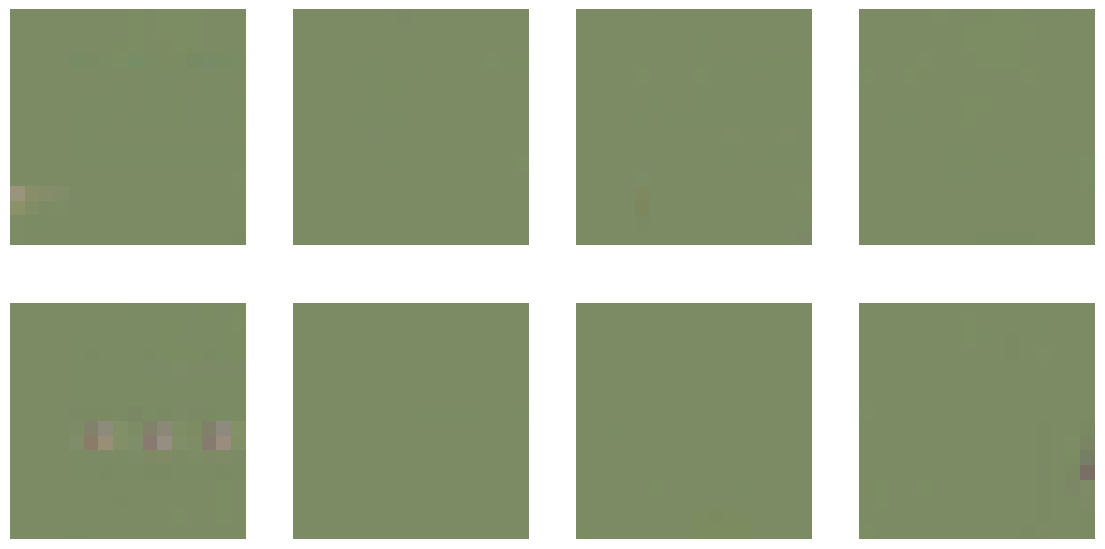

In [24]:
tactile_loader = data.DataLoader(whole_hand_dset, 
                                batch_size  = 128, 
                                shuffle     = True, 
                                num_workers = 8,
                                pin_memory  = True)
for batch_idx, inputs in enumerate(tactile_loader):
    fig = plt.figure(figsize = (14, 7))
    print(inputs.min(), inputs.max())
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])  
        plot_tactile_image(ax, inputs[i])
    break

In [23]:
# Now find the mean and std again through the normalized images
tactile_loader = data.DataLoader(whole_hand_dset, 
                                batch_size  = 128, 
                                shuffle     = True, 
                                num_workers = 8,
                                pin_memory  = True)
byol_whole_hand_mean, byol_whole_hand_std = get_image_stats(
    len(whole_hand_dset), 
    tactile_loader,
    img_size = 16
)

100%|████████████████| 3481/3481 [00:09<00:00, 369.30it/s]

mean: tensor([0.4872, 0.5479, 0.3916])
std:  tensor([0.0046, 0.0022, 0.0046])
